In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torchsummary import summary

In [48]:
DATA_DIR = 'data/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [49]:
class HackathonDataset(Dataset):
    """Hackathon Dataset"""   
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with paths and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform    
        
    def __len__(self):
        return len(self.file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        img_file = self.file.iloc[idx]["image_file_name"]        
        if "22NCL" in img_file:
            img_dir= "guyane/guyane/"
        elif "28PCC" in img_file:
            img_dir = "saint_louis/saint_louis/"  
        elif "29SMD" in img_file:
            img_dir = "dataset_29SMD/dataset_29SMD/"  
        elif "29TNE" in img_file:
            img_dir = "dataset_29TNE/dataset_29TNE/"
        else:
            raise Exception('There is something wrong with image name')    
        image = np.load(self.root_dir + img_dir + img_file + ".npy")
        image = np.moveaxis(image, -1, 0)  # Permute dimensions in order to have Cin, H, W instead of H, W, Cin
        image = image.astype(np.float32)  # We work with float (float32), not double (float64)
        target = self.file.iloc[idx]["z"]
        target = target.astype(np.float32)  # We work with float (float32), not double (float64)
        sample = {'image': image, 'z': target, "image_file_name": img_file}
        if self.transform:
            sample = self.transform(sample)        
        return sample

In [69]:
class Net(nn.Module):
    """Used Network"""

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(6400, 1024)  
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1)
        self.relu4 = nn.ReLU()
        
    def forward(self, x):
        """Given a tensor X of shape (Batch_size, C_in, H, W), compute the output tensor, of shape (Batch_size, )"""
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.flatten(start_dim=1)  # Flatten the 3 last dimensions, keep the 1 dimension (batch_size)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = x.flatten()  # The output dimension should be (Batch_size, ) and not (Batch_size, 1) 
        return x

In [70]:
n_epochs = 2
batch_size = 128

In [71]:
dataset = HackathonDataset(DATA_DIR + 'mixed_train.csv', DATA_DIR)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataset = HackathonDataset(DATA_DIR + 'mixed_validation.csv', DATA_DIR)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
model = Net()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [72]:
summary(model, (4, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 40, 40]             592
              ReLU-2           [-1, 16, 40, 40]               0
         MaxPool2d-3           [-1, 16, 20, 20]               0
            Conv2d-4           [-1, 64, 20, 20]           9,280
              ReLU-5           [-1, 64, 20, 20]               0
         MaxPool2d-6           [-1, 64, 10, 10]               0
            Linear-7                 [-1, 1024]       6,554,624
              ReLU-8                 [-1, 1024]               0
            Linear-9                    [-1, 1]           1,025
             ReLU-10                    [-1, 1]               0
Total params: 6,565,521
Trainable params: 6,565,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.89
Params size (MB): 25.05
Estima

In [74]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    
    # Print Epoch
    print(f"Epoch {epoch + 1}/{n_epochs}")
    
    # Training loop
    for it, batch in enumerate(dataloader):
                
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward propagation through the network
        out = model(batch["image"].to(DEVICE))
        
        # Calculate the loss
        loss = torch.sqrt(criterion(out, batch["z"].to(DEVICE)))  # We take square root because RMSE is the competition's metric
        
        # Track batch loss
        train_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
        #=====Printing part======
        if it%(len(dataloader) // 5) == 0:
            print(f"Number of sample viewed : {it*batch_size}")
    
    # Validation loop
    for it, batch in enumerate(val_dataloader):
                
        # Forward propagation through the network
        out = model(batch["image"].to(DEVICE))
        
        # Calculate the loss
        loss = torch.sqrt(criterion(out, batch["z"].to(DEVICE)))  # We take square root because RMSE is the competition's metric
        
        # Track batch loss
        val_losses.append(loss.item())

Epoch 1/2
Number of sample viewed : 0
Number of sample viewed : 11392
Number of sample viewed : 22784
Number of sample viewed : 34176
Number of sample viewed : 45568
Number of sample viewed : 56960
Epoch 2/2
Number of sample viewed : 0
Number of sample viewed : 11392
Number of sample viewed : 22784
Number of sample viewed : 34176
Number of sample viewed : 45568
Number of sample viewed : 56960


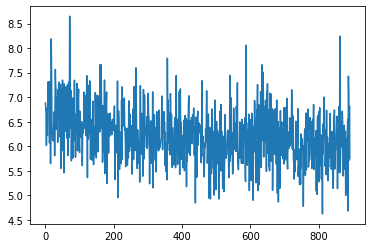

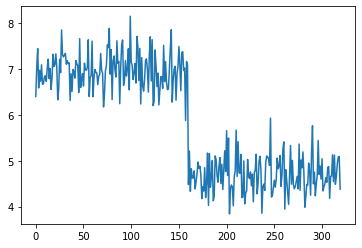

In [75]:
plt.plot(train_losses)
plt.show()
plt.plot(val_losses)
plt.show()

# Evaluation on Test Data

In [76]:
test_dataset = HackathonDataset(DATA_DIR + 'mixed_test.csv', DATA_DIR)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
kaggle_df = pd.DataFrame(columns=['image_file_name', "z"])

In [78]:
data = []

for it, batch in enumerate(test_dataloader):
    out = model(batch["image"].to(DEVICE)).cpu().detach().numpy()
    img_file_names = batch["image_file_name"]
    for i in range(len(img_file_names)):
        data.append([img_file_names[i], out[i]])

kaggle_df = pd.DataFrame(data, columns=['image_id', 'predicted_z'])

In [79]:
kaggle_df.to_csv('predictions/prediction-' + datetime.now().strftime("%d-%m-%y:%H-%M") + '.csv', index=False)